# Defining final simulation workflow

## Imports

In [1]:
# Supressing annoying warnings (!must be done first!)
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning) # doesn't actually seem to do anything about mbuild warnings

# Logging
from rich.progress import Progress, track
from polysaccharide2.genutils.logutils.IOHandlers import LOG_FORMATTER

import logging
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    # force=True
)
LOGGER = logging.Logger(__name__)

from typing import Optional, Union
from pathlib import Path

/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]


## Global parameters

In [2]:
mol_name = 'peg_modified'

pdb_sub = 'simple_polymers'
pdb_src_dir  = Path(f'pdb_test_cleaned/pdbs/{pdb_sub}')
mono_src_dir = Path(f'pdb_test_cleaned/monos/{pdb_sub}')

working_dir = Path(f'workflow_test_{mol_name}')
working_dir.mkdir(exist_ok=True)

## 0) Filetree setup

In [3]:
from shutil import copyfile
from polysaccharide2.genutils.fileutils.pathutils import assemble_path
from polysaccharide2.monomers import MonomerGroup

term_orients = { 
    'peg_modified' : {
        'peg_TERM2' : 'head',
        'peg_TERM3' : 'tail',
    },
    'paam_modified' : {
        'paam_TERM2' : 'head',
        'paam_TERM3' : 'tail',
    },
    'pnipam_modified' : {
        'pnipam_TERM2' : 'head',
        'pnipam_TERM3' : 'tail',
    },
}

starting_dir = working_dir / 'chemistry_seeds'
starting_dir.mkdir(exist_ok=True)

# COPY PDB FILE
pdb_src_path = assemble_path(pdb_src_dir, mol_name, extension='pdb')
assert(pdb_src_path.exists())
pdb_path = assemble_path(starting_dir, mol_name, extension='pdb')
copyfile(pdb_src_path, pdb_path)

# COPY MONOMER FILE WITH ASSIGNED TERMINAL GROUPS
mono_src_path = assemble_path(mono_src_dir, mol_name, extension='json')
assert(mono_src_path.exists())
mono_path = assemble_path(starting_dir, mol_name, extension='json')

monomers = MonomerGroup.from_file(mono_src_path)
monomers.term_orient = term_orients[mol_name]
monomers.to_file(mono_path)

## 5) Analysis

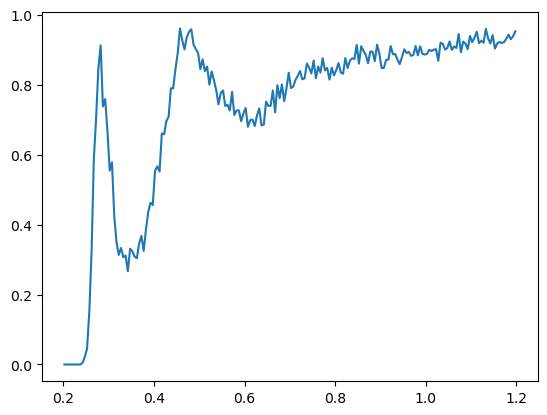

In [9]:
sim_paths_path : Path # -> SimulationPaths

import mdtraj
import matplotlib.pyplot as plt

from polysaccharide2.openmmtools.serialization import SimulationPaths
from polysaccharide2.analysis import mdtrajutils


sim_paths = history['production']['paths']
traj = mdtraj.load(sim_paths.trajectory_path, top=sim_paths.topology_path)
pair_dict = {
    'chain O - water O' : traj.top.select_pairs('not water and element O', 'water and element O')
}
if 'N' in mdtrajutils.unique_elem_types(traj):
    pair_dict['chain N - water O'] = traj.top.select_pairs('not water and element N', 'water and element O')


rdf_dframe = mdtrajutils.acquire_rdfs(traj, pair_dict=pair_dict, min_rad=0.2, max_rad=1.2, rad_unit=nanometer)
radii, rdf = mdtrajutils.rdfs_to_plot_data(rdf_dframe)

plt.plot(radii, rdf)